In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
from datetime import date
from IPython.display import display, HTML
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [2]:
# Common function definitions
def printStats(y_dev, y_pred):
    # Graph
    plt.scatter(y_dev, y_pred)
    plt.plot(y_pred,y_pred,color='black')
    plt.show()
    
    # Stats
    mae = mean_absolute_error(y_dev, y_pred).round(1)
    rmse = round(math.sqrt(mean_squared_error(y_dev, y_pred)),1)
    r2 = r2_score(y_dev, y_pred).round(2)
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R^2: {r2}')
    
def cvGrid(params):
    names = ['param_' + x for x in list(params.keys())]
    return pd.DataFrame(grid.cv_results_)[names+['mean_test_score','std_test_score','rank_test_score','mean_fit_time','mean_score_time','std_fit_time','std_score_time']].sort_values(names)


In [3]:
# Partition training, dev, and test data
allStats = pd.read_csv('../allStats.csv')
X = allStats \
    .loc[:,allStats.columns.str.contains('-\d+') | allStats.columns.str.match('fanPts')] \
    .drop('fanPts',axis=1) \
    .fillna(0)
y = allStats.fanPts

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_dev_raw, X_test_raw, y_dev, y_test = train_test_split(X_test_raw, y_test, test_size=0.5, random_state=0)

# Scale
ss = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(ss.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_dev_std = pd.DataFrame(ss.fit_transform(X_dev_raw), columns=X_dev_raw.columns)
X_test_std = pd.DataFrame(ss.fit_transform(X_test_raw), columns=X_test_raw.columns)

# Manually downselect useful columns
keepCols = \
    X.columns.str.contains('fanPts') | \
    X.columns.str.contains('^complete_pass') | \
    X.columns.str.contains('rush_attempt') | \
    X.columns.str.contains('yards_gained') | \
    X.columns.str.contains('^touchdown')

X_train_select, X_dev_select, X_test_select = X_train_raw.loc[:,keepCols], X_dev_raw.loc[:,keepCols], X_test_raw.loc[:,keepCols]
X_train_std_select, X_dev_std_select, X_test_std_select = X_train_std.loc[:,keepCols], X_dev_std.loc[:,keepCols], X_test_std.loc[:,keepCols]

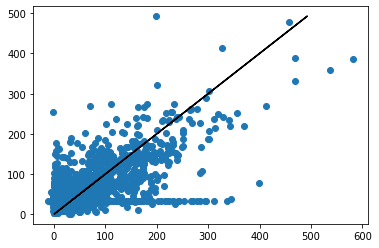

MAE: 37.8
RMSE: 55.0
R^2: 0.47


In [5]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = RandomForestRegressor(oob_score = True)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

OOB Score: 0.47037540839162484
Best Params: {'max_depth': 9, 'n_estimators': 500}



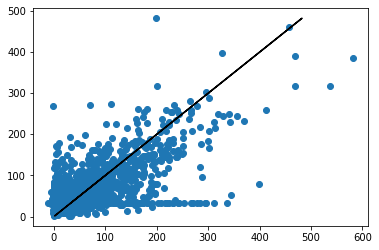

MAE: 37.9
RMSE: 55.0
R^2: 0.47


In [6]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev
    
grid = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid = {
        'max_depth': range(1,10),
        'n_estimators': tuple(list(range(10,100,10)) + [500, 1000]),
    },
    cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1).fit(X_train,y_train)

bestParams = grid.best_params_

rfr = RandomForestRegressor(max_depth=bestParams["max_depth"], n_estimators=bestParams["n_estimators"], oob_score = True, random_state=False, verbose=False)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

print(f'OOB Score: {m.oob_score_}')
print(f'Best Params: {bestParams}\n')
    
printStats(y_dev,y_pred)